In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time
%matplotlib inline

from environments.evil_wgw_env import EvilWindyGridWorld

In [7]:
class EvilWindyGridWorldBase:
    
    def __init__(self, grid_size=(11, 14), visual=False, stochasticity=0.1):
        self.w, self.h = grid_size
        self.visual = visual
        self.stochasticity = stochasticity
        self.reset()
        
    def valid_xy(self, x, y):
        x_ = np.clip(x, 0, self.w-1)
        y_ = np.clip(y, 0, self.h-1)
        return x_, y_
        
    def wind_shift(self, x, y):
        if x == 1: return self.valid_xy(x, y+1)
        elif (x > 1 and x < self.w//2): return self.valid_xy(x, y+2)
        else: return (x, y)
        
    def move(self, a):
        x, y = self.pos
        self.field[x, y] = 0
        x, y = self.wind_shift(x, y)
        
        if a == 0:
            if x + 1 == self.w//2 and y != self.h-4 and y != self.h-7:
                return x, y
            else:
                return(self.valid_xy(x+1, y))
            
        if a == 1: 
            if x == self.w//2:
                return(self.valid_xy(x, y))
            else:
                return(self.valid_xy(x, y+1))
        
        if a == 2: 
            if x - 1 == self.w//2 and y != self.h-4 and y != self.h-7:
                return x, y
            else:
                return(self.valid_xy(x-1, y))
            
        if a == 3: 
            if x == self.w//2:
                return(self.valid_xy(x, y))
            else:
                return(self.valid_xy(x, y-1))            
        
    def reset(self):
        self.field = np.zeros((self.w, self.h))
        x_center = self.w//2
        self.field[x_center, :] = 1
        self.field[x_center, self.h-4] = 0
        self.field[x_center, self.h-7] = 0
        self.field[x_center+1, self.h-6] = -1
        self.field[x_center+1, self.h-8] = -1
        self.field[0,0] = 2
        self.pos = (0, 0)
        return self.pos
    
    def step(self, a, stochastic=True, true_step=True):
        
        if stochastic:
            if np.random.rand() < self.stochasticity:
                a = np.random.randint(4)
        
        self.field[self.pos] = 0
        self.pos = self.move(a)
        
        done = False
        reward = 0
        if self.pos == (self.w-1, 0):
            done = True
            reward = 1
        if (self.pos == (self.w//2+1, self.h-6) 
                or self.pos == (self.w//2+1, self.h-8)):
            done = True
            reward = -1
        if self.visual:
            obs = np.rot90(self.field)
        else:
            obs = self.pos
        
        if true_step:
            self.field[self.pos] = 2
            
        return obs, reward, done
    
    def play_with_policy(self, policy, max_iter=100):
        self.reset()
        for i in range(max_iter):
            pos = self.pos
            a = np.argmax(policy[pos])
            ns, reward, done = self.step(a)
            img = np.rot90(1-self.field)
            plt.imshow(img, cmap='gray')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.2)
            if done: break
        display.clear_output(wait=True)

In [8]:
def plot_average(r, eta):
    ret = np.cumsum(r, dtype=np.float)
    ret[eta:] = ret[eta:] - ret[:-eta] 
    y = ret[eta - 1:] / eta
    return y

def plot_max(r, eta):
    return r[eta-1:]

def plot_means_and_stdevs(x, y, tau, figsize=(8, 5), color='dodgerblue'):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    means = np.cumsum(y, dtype=np.float)
    stdevs = np.cumsum(np.square(y), dtype=np.float)
    
    means[tau:] = means[tau:] - means[:-tau]
    means = means[tau-1:] / tau
    
    stdevs[tau:] = stdevs[tau:] - stdevs[:-tau]
    stdevs = stdevs[tau-1:] / tau - np.square(means)
    stdevs = np.sqrt(stdevs)
    
    lower = means - stdevs
    upper = means + stdevs
    
    x = plot_max(x, tau)
    
    ax.plot(x, means, color=color)
    ax.fill_between(x, lower, means, alpha=0.2, where=lower <= means, facecolor=color)
    ax.fill_between(x, upper, means, alpha=0.2, where=upper >= means, facecolor=color)
    plt.ylim([-1.1, 1.6])
    
    ax.grid()
    
def plot_two_lines(
        x, ys, tau, figsize=(12, 6),
        colors=["dodgerblue", "mediumseagreen"],
        labels=["Quantilee", "Standard"]):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    x = plot_max(x, tau)
    for i in range(len(ys)):
        means = np.cumsum(ys[i], dtype=np.float)
        stdevs = np.cumsum(np.square(ys[i]), dtype=np.float)

        means[tau:] = means[tau:] - means[:-tau]
        means = means[tau-1:] / tau

        stdevs[tau:] = stdevs[tau:] - stdevs[:-tau]
        stdevs = stdevs[tau-1:] / tau - np.square(means)
        stdevs = np.sqrt(stdevs) / 2

        lower = means - stdevs
        upper = means + stdevs

        

        ax.plot(x, means, color=colors[i], label=labels[i])
        ax.fill_between(x, lower, means, alpha=0.2, where=lower <= means, facecolor=colors[i])
        ax.fill_between(x, upper, means, alpha=0.2, where=upper >= means, facecolor=colors[i])
        ax.legend()

    plt.grid()
    
def plot_learning_curve(path, tau=100, figsize=(8, 5), x_scale=1000000, color='dodgerblue'):
    r = np.load(path+"/learning_curve.npz")['r']
    f_train = np.load(path + "/learning_curve.npz")["f"]/x_scale
    
    plot_means_and_stdevs(f_train, r, tau=tau, figsize=figsize, color=color)
    
def plot_reward_distribution(path, from_episode=0, num_episodes=100, bins=None):
    r = np.load(path+"/learning_curve.npz")['r']
    plt.hist(r[from_episode:from_episode+num_episodes], bins=bins,
             color='dodgerblue', edgecolor='black', linewidth=1.5)
    plt.grid()
    
def compare_two_distributions(path, from_episode1=0, from_episode2=100, 
                              num_episodes=100, bins=None):
    r = np.load(path+"/learning_curve.npz")['r']
    
    hist1 = r[from_episode1:from_episode1+num_episodes]
    hist2 = r[from_episode2:from_episode2+num_episodes]
    hist12 = np.concatenate((hist1, hist2))
    
    left = np.min(hist12)
    right = np.max(hist12)
    
    plt.hist(hist1, bins=bins, range=[left, right], color='dodgerblue', 
             edgecolor='black', linewidth=1.5, alpha=0.7)
    plt.hist(hist2, bins=bins, range=[left, right],color='mediumseagreen', 
             edgecolor='black', linewidth=1.5, alpha=0.7)
    plt.grid()

def plot_performance(path, eta=10, x_scale=1000000):
    r_train = np.load(path + "/learning_curve.npz")["r"]
    f_train = np.load(path + "/learning_curve.npz")["f"]/x_scale
    x = plot_average(f_train, eta)
    y = plot_average(r_train, eta)
    plt.plot(x, y)
    plt.grid()
    
def plot_lifetimes(path, eta=10, x_scale=1000000):
    l_train = np.load(path + "/learning_curve.npz")["l"]
    f_train = np.load(path + "/learning_curve.npz")["f"]/x_scale
    x = plot_average(f_train, eta)
    y = plot_average(l_train, eta)
    plt.plot(x, y)
    plt.grid()
    
def plot_compare(paths, eta, x_scale=1000000, figsize=(8, 5)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    r, f = [], []
    for i in range(len(paths)):
        r = np.load(paths[i] + "/learning_curve.npz")["r"]
        f = np.load(paths[i] + "/learning_curve.npz")["f"]/x_scale
        x = plot_max(f, eta)
        y = plot_average(r, eta)
        ax.plot(x, y, label=paths[i].split("/")[1], lw=3)
        ax.legend()
    ax.grid()
    
def plot_average2(paths, eta, x_scale=1000000, figsize=(8, 5)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    r, f, ys = [], [], []
    for i in range(len(paths)):
        r = np.load(paths[i] + "/learning_curve.npz")["r"]
        f = np.load(paths[i] + "/learning_curve.npz")["f"]
        
        y = gen_equal(r, f)
        x = np.arange(0, 1800000, 100)
        
        x = plot_max(x, eta)
        y = plot_average(y, eta)
        ys.append(y)
    s = np.zeros_like(y)
    for i in range(len(paths)):
        s += ys[i]
    s = s / len(paths)
    ax.plot(x/x_scale, s, lw=3)
    ax.grid()
    return s
    
def plot_compare_lifetimes(paths, eta, x_scale=1000000, figsize=(8, 5)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i in range(len(paths)):
        f = np.load(paths[i] + "/learning_curve.npz")["f"]
        x = plot_max(f[:-1], eta)
        y = plot_average(f[1:] - f[:-1], eta)
        ax.plot(x, y, label=paths[i].split("/")[1])
        ax.legend()
    ax.grid()
    
def plot_compare_equal(paths, eta, x_scale=1000000):
    
    min_l = np.inf
    for i in range(len(paths)):
        l = len(np.load(paths[i] + "/learning_curve.npz")["r"])
        if l < min_l:
            min_l = l
    min_l = int(min_l)
    
    r, f = [], []
    for i in range(len(paths)):
        r = np.load(paths[i] + "/learning_curve.npz")["r"]
        f = np.load(paths[i] + "/learning_curve.npz")["f"]/x_scale
        x = plot_average(f, eta)
        y = plot_average(r, eta)
        plt.plot(x[:min_l], y[:min_l])
    plt.grid()

In [9]:
class QTable:
    
    def __init__(self, env, gamma=0.99):
        self.w, self.h = env.w, env.h
        self.q = np.zeros((self.w, self.h, 4))
        self.pi = np.ones((self.w, self.h, 4)) / 4
        self.env = env
        self.env.reset()
        self.alpha = 0.3
        self.gamma = gamma
        
    def update_xya(self, x, y, a):
        td_target = 0
        for act in range(4):
            if (act == a):
                param = 1.0 - 0.75 * self.env.stochasticity
            else:
                param = 0.25 * self.env.stochasticity

            self.env.pos = x, y
            next_pos, reward, done = self.env.step(
                act, stochastic=False, true_step=False)
            x_, y_ = next_pos

            if (x, y) != (self.w-1, 0):
                q_ = (self.q[x_,y_]*self.pi[x_,y_]).sum()
                td_target += param * (reward + self.gamma * q_ * (1 - done))

        self.q[x,y,a] = self.q[x,y,a] + self.alpha * (td_target - self.q[x,y,a])
        self.env.step(a, stochastic=False)
            
    def update_field(self, num_times=10):
        q_old = self.q.copy()
        for i in range(num_times):
            for x in range(self.w):
                for y in range(self.h):
                    for a in range(4):
                        if (x == self.w//2):
                            if (y == self.h-4 or y == self.h-7):
                                self.update_xya(x,y,a)
                        else: self.update_xya(x,y,a)
        res = np.linalg.norm(q_old-self.q)
        return res
            
    def update_policy(self):
        new_pi = np.zeros((self.w, self.h, 4))
        best_acts = np.argmax(self.q, axis=2)
        for a in range(4):
            indices = np.where(best_acts == a)
            new_pi[:,:,a][indices] = 1
        self.pi = new_pi
        
    def run_policy_iteration(self, pol_impr_times=100, pol_eval_times=10, tol=1e-6):
        for i in range(pol_impr_times):
            res = self.update_field(pol_eval_times)
            self.update_policy()
            if (res < tol): break
                
    def plot_q_values(self, figsize=(15, 5)):
        fig, ax = plt.subplots(1, 4, figsize=figsize)
        for a in range(4):
            img = np.rot90(self.q[:,:,a])
            ax[a].imshow(img, cmap='gray', vmin=0, vmax=1)
            
    def q_learning(self, max_num_iter=100, max_ep_len=100, lr=0.1, state=(0, 0)):
        self.q = np.zeros((self.w, self.h, 4))
        eps = 1
        eps_fin = 0.1
        delta_eps = (eps - eps_fin) / 1000
        
        x_eval, y_eval = state
        a_eval = 0
        td_values = []
        
        for it in range(max_num_iter):
            eps = max(eps, eps_fin)
            x, y = self.env.reset()
            td_values.append(self.q[x_eval,y_eval,a_eval])
            for step in range(max_ep_len):
                if np.random.rand() < eps:
                    a = np.random.randint(4)
                else:
                    a = np.argmax(self.q[x,y])
                (x_, y_), reward, done = self.env.step(a)
                a_ = np.argmax(self.q[x_,y_])
                td_error = reward + self.gamma*self.q[x_,y_,a_]*(1-done) - self.q[x,y,a]
                self.q[x,y,a] = self.q[x,y,a] + lr * td_error
                x, y = x_, y_
                if done: break
            eps = eps - delta_eps
            
            
            if it % 2000 == 0:
                lr = lr * 0.8
        
        return td_values

    def qrq_learning(self, num_atoms=32, max_num_iter=100, max_ep_len=100, lr=0.1,
                     state=(0, 0)):
        self.z = np.zeros((self.w, self.h, 4, num_atoms))
        self.q = np.zeros((self.w, self.h, 4))
        eps = 1
        eps_fin = 0.1
        delta_eps = (eps - eps_fin) / 1000
        
        tau_min = 1 / (2 * num_atoms) 
        tau_max = 1 - tau_min
        taus = np.linspace(start=tau_min, stop=tau_max, num=num_atoms)
        
        x_eval, y_eval = state
        a_eval = 0
        
        hists = []
        qrtd_values = []
        
        for it in range(max_num_iter):
            eps = max(eps, eps_fin)
            x, y = self.env.reset()
            qrtd_values.append(self.z[x_eval, y_eval, a_eval].mean())
            for step in range(max_ep_len):
                if np.random.rand() < eps:
                    a = np.random.randint(4)
                else:
                    a = np.argmax(self.z[x,y].mean(axis=-1), axis=-1)
                (x_, y_), reward, done = self.env.step(a)
                a_ = np.argmax(self.z[x_,y_].mean(axis=-1), axis=-1)
                
                delta = (reward + self.gamma * self.z[x_,y_,a_][:,None] * \
                         (1-done) < self.z[x,y,a][None,:]).mean(axis=0)
                qrtd_error = taus - delta
                self.z[x,y,a] = self.z[x,y,a] + lr * qrtd_error
                
                x, y = x_, y_
                if done: break
            self.q = np.mean(self.z, axis=-1)
            eps = eps - delta_eps   
            
            
            
            if it % 100 == 0:
                hists.append(self.z[0,0,0].copy())
                
            if it % 2000 == 0:
                lr = lr * 0.8
        return hists, np.array(qrtd_values)

In [10]:
env = EvilWindyGridWorld(grid_size=(7, 10), visual=True, stochasticity=0)
num_actions = 4
s = env.reset()

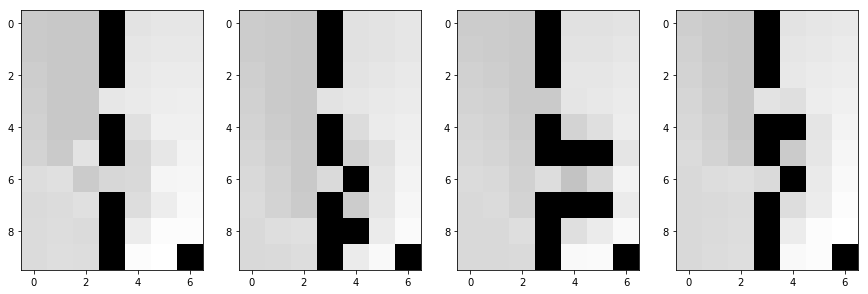

In [11]:
wgw = EvilWindyGridWorldBase((7, 10), stochasticity=0.1)
qt = QTable(wgw)
qt.run_policy_iteration()
qt.plot_q_values()

In [12]:
qt.update_policy()

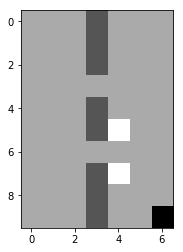

In [13]:
wgw.play_with_policy(qt.pi)

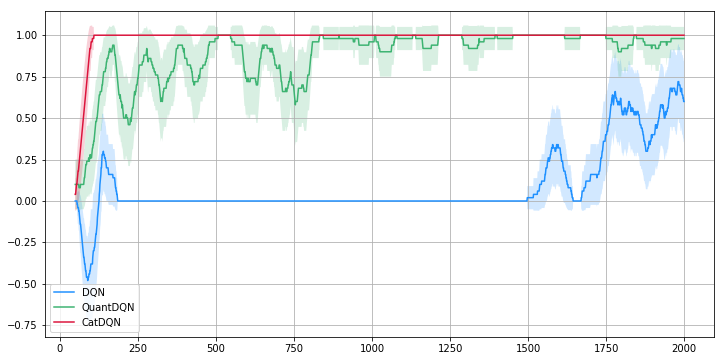

In [46]:
path = "evil_wgw_models/logs/exp0_1/model/learning_curve.npz"
train = np.load(path)["train"]
test = np.load(path)["test"]
quant, dqn, cat = test[0, :], test[1, :], test[2, :]
plot_two_lines(np.arange(len(dqn)),
               ys=[dqn, quant, cat],
               labels=["DQN", "QuantDQN", "CatDQN"],
               colors=["dodgerblue", "mediumseagreen", "crimson"],
               tau=50)

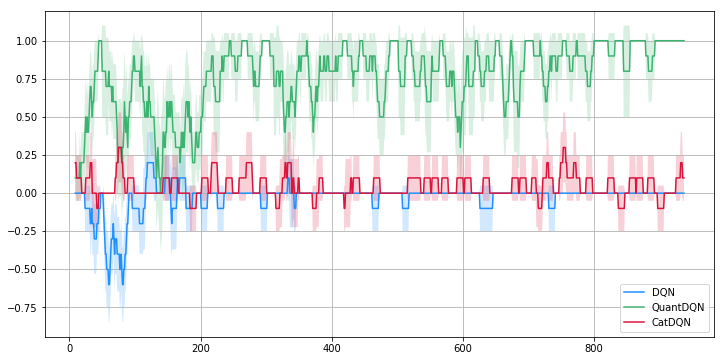

In [47]:
path = "evil_wgw_models/logs/exp02_1/model/learning_curve.npz"
train = np.load(path)["train"]
test = np.load(path)["test"]
quant, dqn, cat = test[0, :], test[1, :], test[2, :]
plot_two_lines(np.arange(len(dqn)),
               ys=[dqn, quant, cat],
               labels=["DQN", "QuantDQN", "CatDQN"],
               colors=["dodgerblue", "mediumseagreen", "crimson"],
               tau=10)

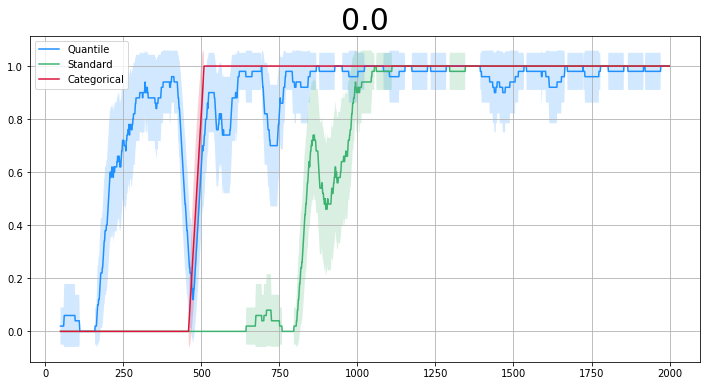

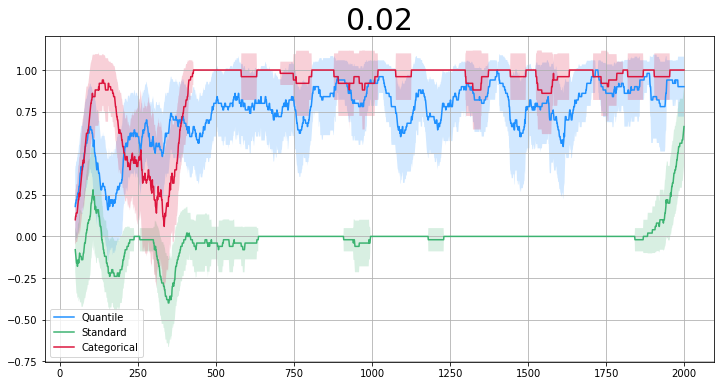

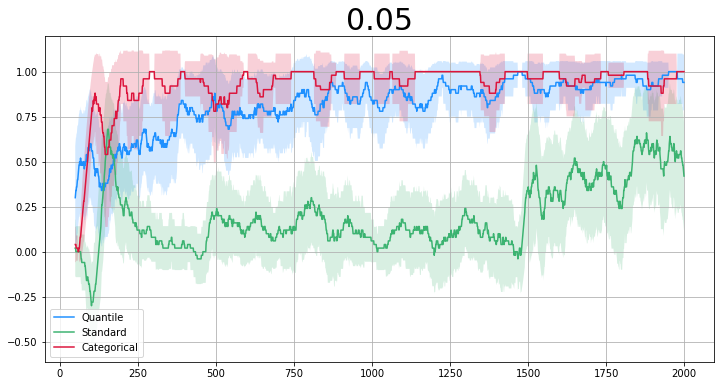

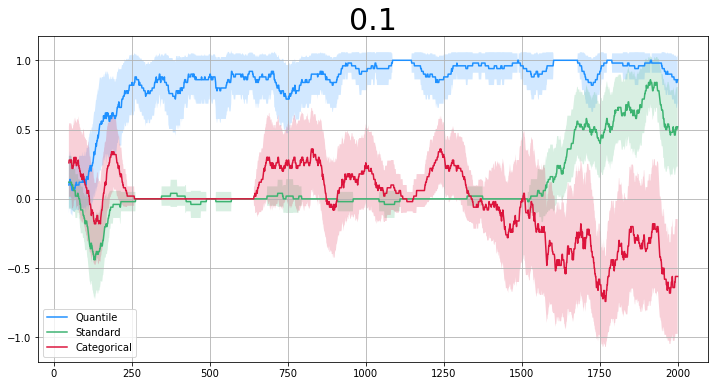

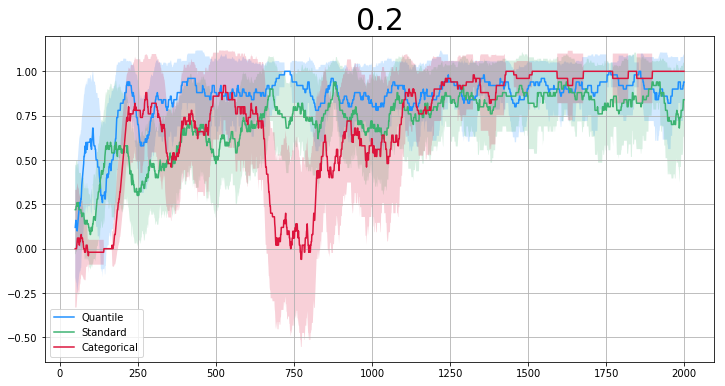

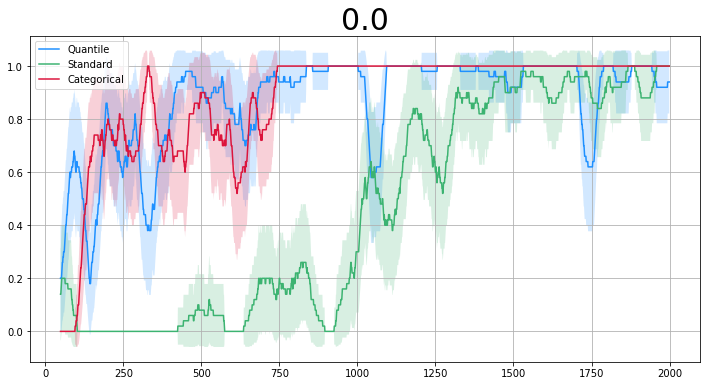

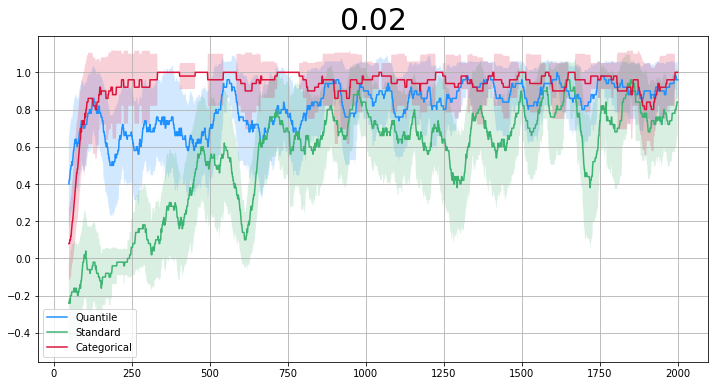

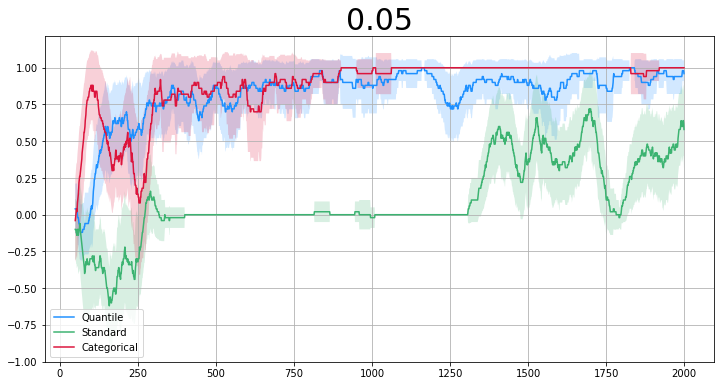

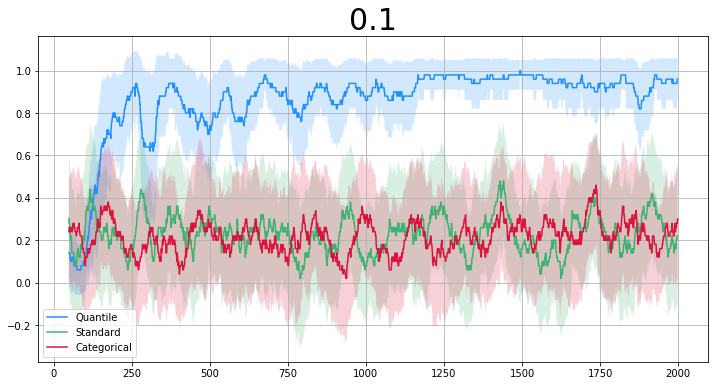

In [110]:
for i in range(2):
    for stoc in [0.0, 0.02, 0.05, 0.1, 0.2]:
        
        if stoc == 0.2 and i == 1:
            break

        path = "evil_wgw_models/dec17/exp"+str(stoc)[2:]+"_"+str(i+1)+"/model/learning_curve.npz"

        #path = "evil_wgw_models/dec17/exp05_2/model/learning_curve.npz"
        train = np.load(path)["train"]
        test = np.load(path)["test"]

        algo1 = test[0,:]
        algo2 = test[1,:]
        algo3 = test[2, :]

        plot_two_lines(
            np.arange(len(algo1)),
            ys=[algo1, algo2, algo3], tau=50,
            title=str(stoc),
            colors=["dodgerblue", "mediumseagreen", "crimson"],
            labels=["Quantile", "Standard", "Categorical"])